### Sampling - Baseline : Traditional Time Series Model (ES, AR, SARIMA) 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_data(dataset):
    data = pd.read_csv(f'./data/{dataset}_MRR.csv')
    mrr_data = data['MRR']
    mrr_train = mrr_data[:int(len(mrr_data) * 0.7)]
    mrr_test = mrr_data[int(len(mrr_data) * 0.7):] 

    return mrr_train, mrr_test

In [4]:
# print the amount of data
A456_train, A456_test = get_data('A456')
print('A456_train :', A456_train.shape[0])
print('A456_test : ', A456_test.shape[0])

B456_train, B456_test = get_data('B456')
print('B456_train :', B456_train.shape[0])
print('B456_test : ', B456_test.shape[0])

A456_train : 674
A456_test :  289
B456_train : 700
B456_test :  301


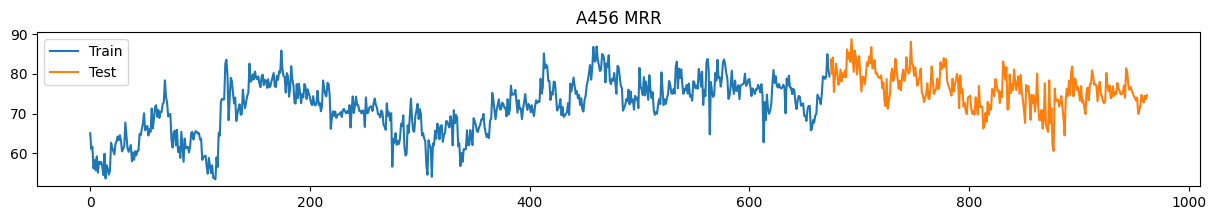

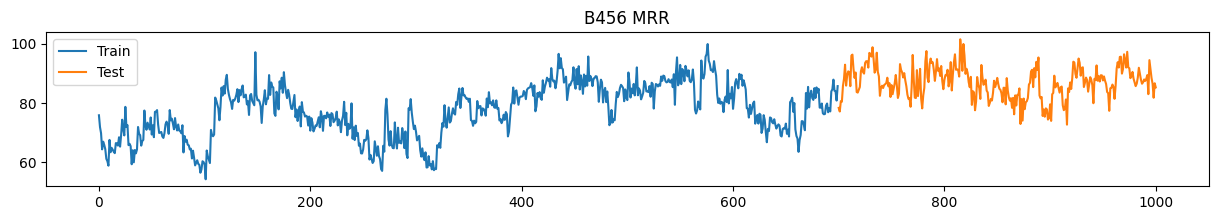

In [5]:
# plot the series after split
plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(A456_train.shape[0]), A456_train.tolist(), label='Train')
plt.plot(range(A456_train.shape[0], A456_train.shape[0] + A456_test.shape[0]), A456_test.tolist(), label='Test')
plt.title('A456 MRR')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(15, 2), dpi=100)
plt.plot(range(B456_train.shape[0]), B456_train.tolist(), label='Train')
plt.plot(range(B456_train.shape[0], B456_train.shape[0] + B456_test.shape[0]), B456_test.tolist(), label='Test')
plt.title('B456 MRR')
plt.legend(loc='upper left')
plt.show()

#### VM Model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
import lightgbm
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from scipy.stats import kurtosis, skew
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler

In [7]:
# with former MRR X data
def get_orig_data(dataset):

    train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0).reset_index(drop=True)
    test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0).reset_index(drop=True)

    short_sampled_orig = train_orig.iloc[316*2:, :].reset_index(drop=True)
    former_mrr_sampled = train_orig.iloc[:-316*2, -1].rename('former_MRR').reset_index(drop=True)
    addmrr_sampled_orig = pd.concat([short_sampled_orig, former_mrr_sampled], axis=1)
    fmrr_scaler = MinMaxScaler().fit(addmrr_sampled_orig[['former_MRR']])
    addmrr_sampled_orig['former_MRR'] = fmrr_scaler.transform(addmrr_sampled_orig[['former_MRR']])

    short_unsampled_orig = train_orig.iloc[316*1:, :].reset_index(drop=True)
    former_mrr_unsampled = train_orig.iloc[:-316*1, -1].rename('former_MRR').reset_index(drop=True)
    addmrr_unsampled_orig = pd.concat([short_unsampled_orig, former_mrr_unsampled], axis=1)
    addmrr_unsampled_orig['former_MRR'] = fmrr_scaler.transform(addmrr_unsampled_orig[['former_MRR']])

    former_mrr_test = pd.concat([train_orig.iloc[-316*1:, -1], test_orig.iloc[:-316*1, -1]], ignore_index=True).rename("former_MRR").reset_index(drop=True)
    addmrr_test_orig = pd.concat([test_orig, former_mrr_test], axis=1)
    addmrr_test_orig['former_MRR'] = fmrr_scaler.transform(addmrr_test_orig[['former_MRR']])
    
    return addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig

def get_stats_data(data):
    orig_X = data.iloc[:, :-2].to_numpy()
    orig_X = orig_X.reshape(-1, 316, orig_X.shape[1])
    orig_y = data.iloc[:, -2].tolist()
    data_y = [orig_y[i] for i in range(0, len(orig_y), 316)]
    former_mrr = data.iloc[:, -1].tolist()
    former_mrr = [former_mrr[i] for i in range(0, len(former_mrr), 316)]
    
    # calculate statistics
    means = np.mean(orig_X, axis=1)
    stds = np.std(orig_X, axis=1)
    medians = np.median(orig_X, axis=1)
    mins = np.min(orig_X, axis=1)
    maxs = np.max(orig_X, axis=1)
    kurts = kurtosis(orig_X, axis=1)
    skews = skew(orig_X, axis=1)
    stats_X = np.hstack([means, stds, medians, mins, maxs, kurts, skews])
    stats_X = np.nan_to_num(stats_X, nan=0.0)

    # add MRR
    former_mrr = np.array(former_mrr).reshape(-1,1)
    data_X = np.concatenate((stats_X, former_mrr), axis=1)

    return data_X, data_y

def fit_XGB(X_train, y_train):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',  # 回歸問題
        'max_depth': 3,                    # 樹的最大深度
        'learning_rate': 0.01,              # 學習率
        'n_estimators': 200                # 樹的數量
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

def fit_RF(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)
    return model

def fit_KNN(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def fit_MLP(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(128, 16), activation='relu', solver='adam', max_iter=2000, random_state=2)
    model.fit(X_train, y_train)
    return model

def get_Stats_pred(dataset, mode_type):  # model_type: 'XGB'/'RF'/'KNN'
    
    addmrr_sampled_orig, addmrr_unsampled_orig, addmrr_test_orig = get_orig_data(dataset)
    # retain only sampled section
    sampled_train_orig = pd.concat([addmrr_sampled_orig.iloc[i:i+316] for i in range(0, len(addmrr_sampled_orig), 316*2)], ignore_index=True)
    unsampled_train_orig = pd.concat([addmrr_unsampled_orig.iloc[i:i+316] for i in range(316, len(addmrr_unsampled_orig), 316*2)], ignore_index=True)
    #test_orig = pd.concat([test_orig.iloc[i:i+316] for i in range(0, len(test_orig), 316*2)], ignore_index=True)

    all_test_orig = pd.concat([unsampled_train_orig, addmrr_test_orig], ignore_index=True)
    extend_test_orig = pd.concat([addmrr_unsampled_orig.iloc[-316*4:], addmrr_test_orig], ignore_index=True)

    y_pred = {}
    X_train, y_train = get_stats_data(sampled_train_orig)

    data_modes = {'unsampled':unsampled_train_orig, 'test':addmrr_test_orig, 'all':all_test_orig, 'extend':extend_test_orig}
    for mode, data in data_modes.items():
        match mode_type:
            case 'XGB':
                model = fit_XGB(X_train, y_train)
            case 'RF':
                model = fit_RF(X_train, y_train)
            case 'KNN':
                model = fit_KNN(X_train, y_train)
            case 'MLP':
                model = fit_MLP(X_train, y_train)

        X_test, y_test = get_stats_data(data)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)

        print('------------------------------------------------')
        print(mode)
        print(f"statistic-{mode_type} VM test loss", round(mse, 3))
        y_pred[mode] = model.predict(X_test)

    return y_pred

In [8]:
A456_vm_pred = get_Stats_pred('A456','RF')
A456_vm_train = A456_vm_pred['unsampled']
A456_vm_test = A456_vm_pred['test']

------------------------------------------------
unsampled
statistic-RF VM test loss 4.381
------------------------------------------------
test
statistic-RF VM test loss 12.192
------------------------------------------------
all
statistic-RF VM test loss 7.993
------------------------------------------------
extend
statistic-RF VM test loss 12.179


In [9]:
B456_vm_pred = get_Stats_pred('B456','RF')
B456_vm_train = B456_vm_pred['unsampled']
B456_vm_test = B456_vm_pred['test']

------------------------------------------------
unsampled
statistic-RF VM test loss 5.976
------------------------------------------------
test
statistic-RF VM test loss 17.214
------------------------------------------------
all
statistic-RF VM test loss 11.18
------------------------------------------------
extend
statistic-RF VM test loss 17.186


In [10]:
def combine_vm_data(train, test, vm_train, vm_test):
    train = train[2:].reset_index(drop=True)
    com_trian = [train[i] if i % 2 == 0 else vm_train[int(i / 2)] for i in range(len(train))]
    test = test.reset_index(drop=True)
    com_test = [test[i] if i % 2 == 0 else vm_test[i] for i in range(len(test))]

    return com_trian, com_test

A456_com_train, A456_com_test = combine_vm_data(A456_train, A456_test, A456_vm_train, A456_vm_test)
B456_com_train, B456_com_test = combine_vm_data(B456_train, B456_test, B456_vm_train, B456_vm_test)

#### PHM model

Exponential Smoothing

In [10]:
def es_model(train, test, truth, title, seasonal=False):
    
    #train = train.to_list()
    #test = test.to_list()
    
    # 初始化模型的訓練數據
    rolling_train = train.copy()

    # 保存滾動預測結果
    es_pred = []

    # 滾動預測過程
    for actual in test:
        # 使用當前訓練數據擬合模型
        if seasonal:
            model = ExponentialSmoothing(rolling_train, trend='add', seasonal="mul", seasonal_periods=25)
        else:
            model = ExponentialSmoothing(rolling_train, trend='add', seasonal=None)
        fit = model.fit()
        
        # 預測下一步
        forecast = fit.forecast(steps=1)[0]
        es_pred.append(forecast)
        
        # 將當前真實值加入訓練數據
        rolling_train.append(actual)

    # calculate the MSE
    mse = mean_squared_error(truth, es_pred)
    print(f'{title} MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(truth)), truth, label='Test')
    plt.plot(range(len(train), len(train) + len(es_pred)), es_pred, label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

A456 MSE : 12.212


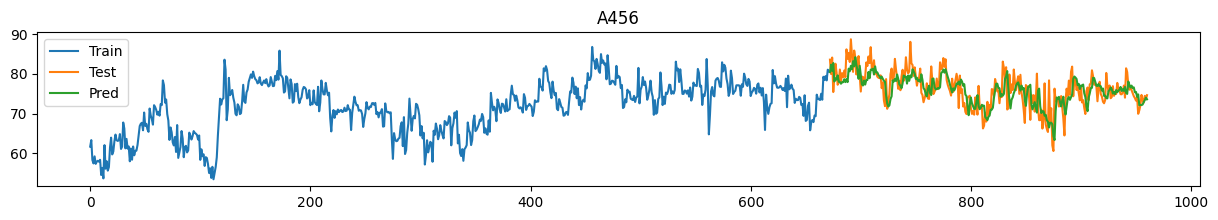

B456 MSE : 16.625


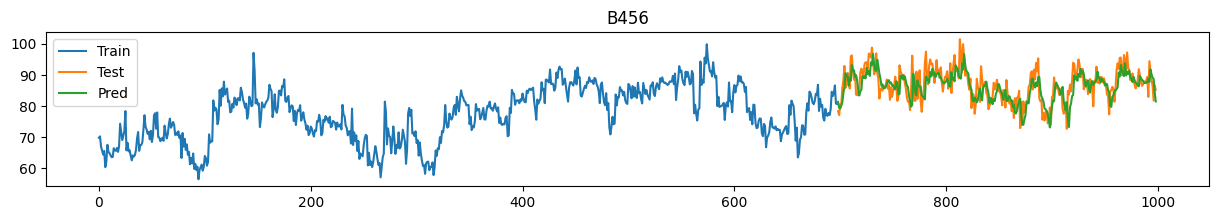

In [11]:
# Exponential Smoothing
es_model(A456_com_train, A456_com_test, A456_test, 'A456')
es_model(B456_com_train, B456_com_test, B456_test, 'B456')

A456 MSE : 12.36


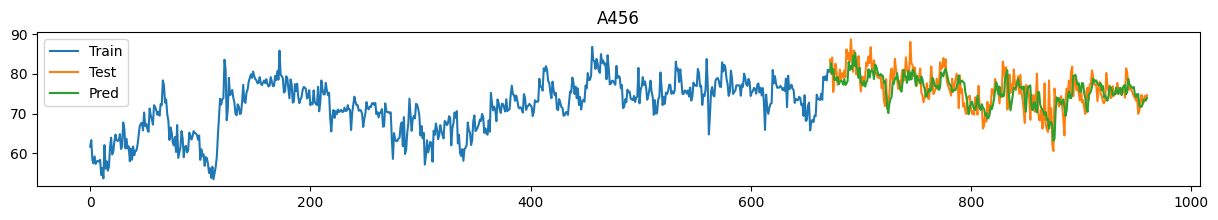

B456 MSE : 17.216


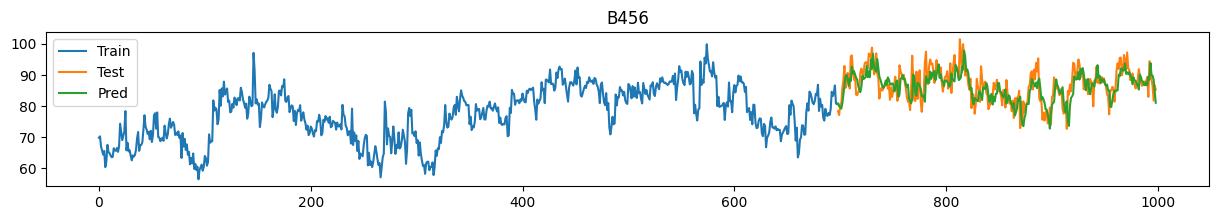

In [12]:
# Exponential Smoothing (25)
es_model(A456_com_train, A456_com_test, A456_test, 'A456', seasonal=True)
es_model(B456_com_train, B456_com_test, B456_test, 'B456', seasonal=True)

AR model

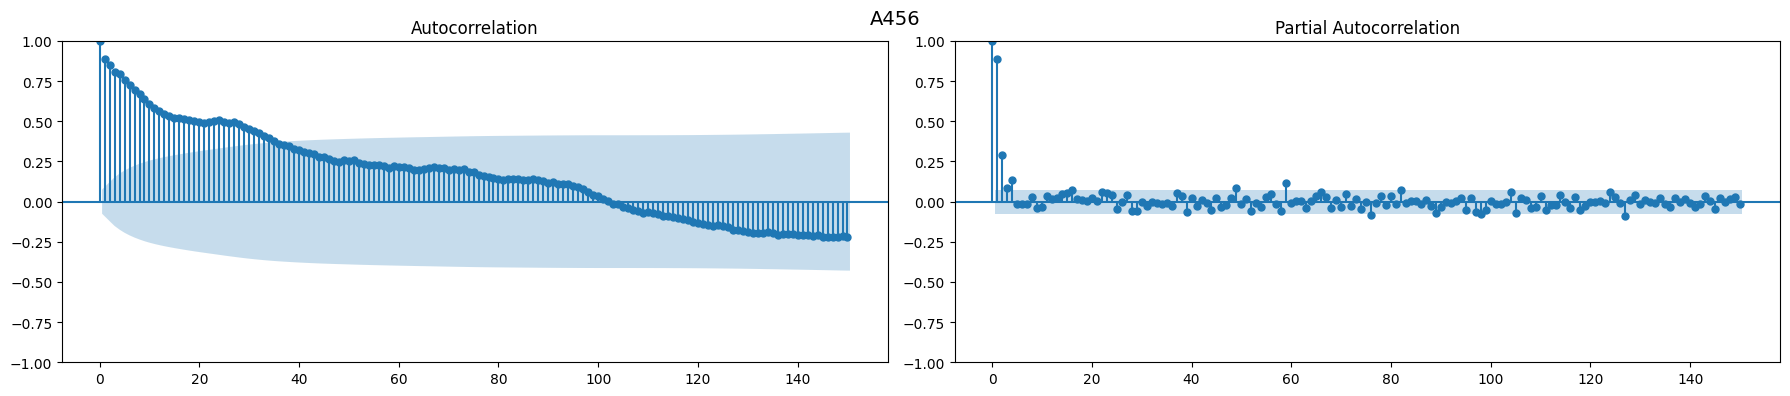

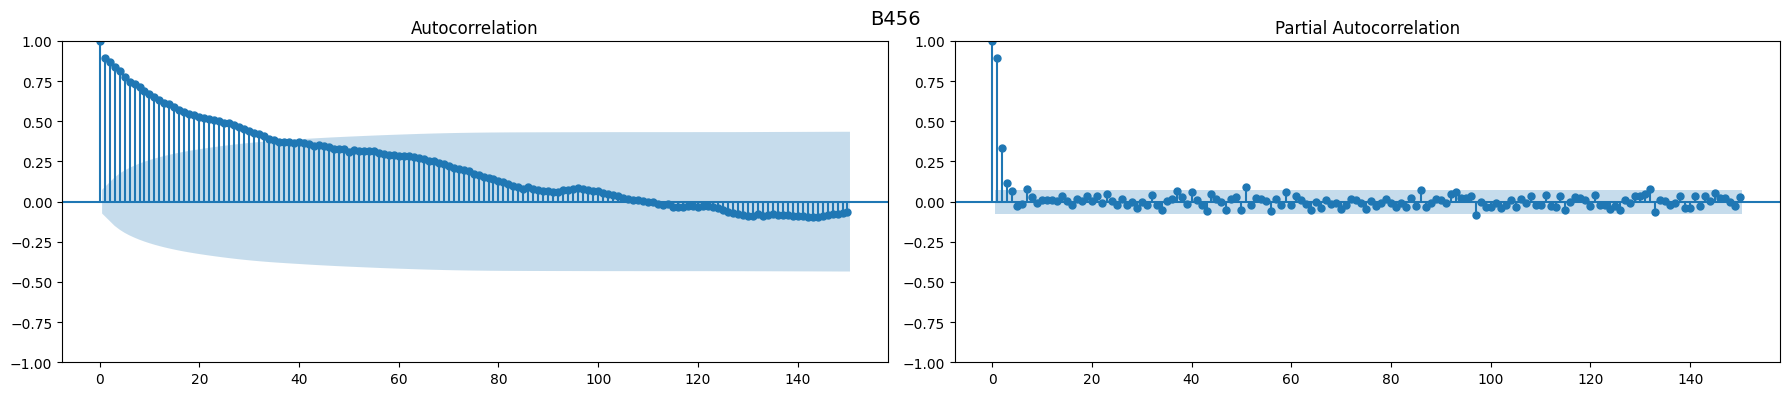

In [ ]:
# plot ACF and PACF
def plot_ACF_PACF(data, title):

    plt.figure(figsize=(18, 4), dpi=100)

    # ACF
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=150, ax=plt.gca())

    # PACF
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=150, ax=plt.gca())

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(title, fontsize=14)
    plt.show()

plot_ACF_PACF(A456_train, 'A456')
plot_ACF_PACF(B456_train, 'B456')

In [39]:
# use auto_arima funciton to select best AR model
def ar_selecting(train):
    autoarima = auto_arima(
        train,
        start_p=0,
        start_q=0,
        d=0,
        max_p=5,
        max_q=5,
        m=25,  # seasonal
        out_of_sample_size=10,
        suppress_warnings=True,
        rolling=True,
        error_action='ignore')

    print(autoarima.summary())

print('A456 best AR')
ar_selecting(A456_train)
print('B456 best AR')
ar_selecting(B456_train)

A456 best AR
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  674
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1683.566
Date:                Thu, 21 Nov 2024   AIC                           3379.133
Time:                        01:03:26   BIC                           3406.212
Sample:                             0   HQIC                          3389.619
                                - 674                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2581      1.231      3.458      0.001       1.845       6.671
ar.L1          0.5766      0.037     15.466      0.000       0.504       0.650
ar.L2          0.2014      0.046      4

In [11]:
# we select the AR(4) for both A456 and B456
def ar_model(train, test, truth, title):
    # fit the model
    ar = ARIMA(order=(4, 0, 0))
    ar_model = ar.fit(train)
    print(ar_model.summary())

    # rolling forecasting
    rolling_preds = []
    first_pred = ar_model.predict(n_periods=1)
    rolling_preds.append(first_pred)
    for i in range(len(test) - 1):
        ar_model.update(test[i])
        new_preds = ar_model.predict(n_periods=1)
        rolling_preds.append(new_preds)

    # calculate the MSE
    mse = mean_squared_error(truth, rolling_preds)
    print('MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(truth)), truth, label='Test')
    plt.plot(range(len(train),
                   len(train) + len(rolling_preds)),
             rolling_preds,
             label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1617.695
Date:                Wed, 22 Jan 2025   AIC                           3247.389
Time:                        12:14:40   BIC                           3274.451
Sample:                             0   HQIC                          3257.870
                                - 672                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6963      1.185      3.119      0.002       1.373       6.019
ar.L1          0.6100      0.039     15.714      0.000       0.534       0.686
ar.L2          0.1337      0.037      3.596      0.0

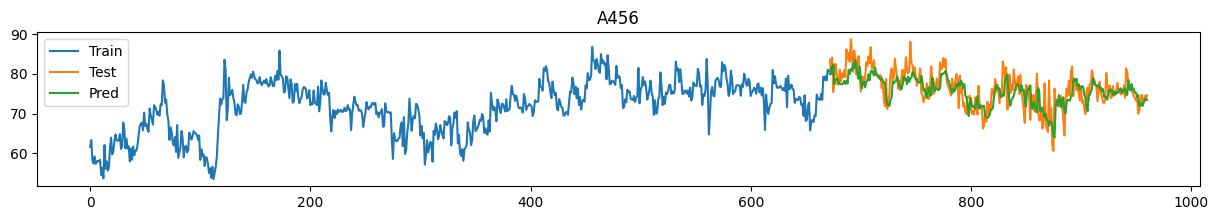

In [12]:
ar_model(A456_com_train, A456_com_test, A456_test, 'A456')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1893.796
Date:                Wed, 22 Jan 2025   AIC                           3799.593
Time:                        12:15:06   BIC                           3826.899
Sample:                             0   HQIC                          3810.148
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4140      1.272      3.469      0.001       1.920       6.908
ar.L1          0.5480      0.035     15.700      0.000       0.480       0.616
ar.L2          0.2468      0.042      5.920      0.0

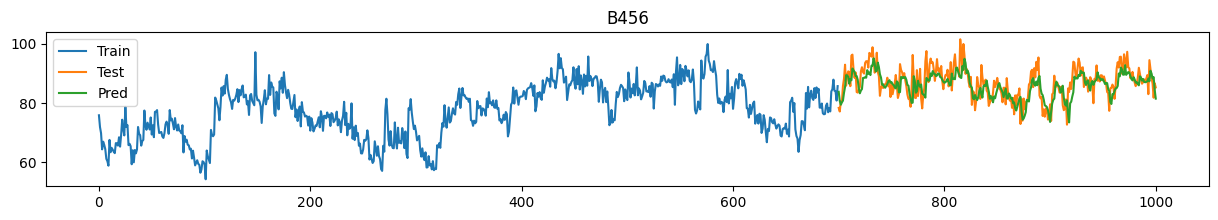

In [13]:
ar_model(B456_train, B456_com_test, B456_test, 'B456')

ARIMA model

In [ ]:
# select the best ARIMA model by AIC and BIC
def get_arima_aic(data, p, stat=True):
    for i in range(1, p+1):
        model = ARIMA(order=(4, 0, 0), seasonal_order=(i, 0, 0, 25), enforce_stationary=stat)
        model.fit(data)
        print(f'SARIMA(4,0,0),({i},0,0,25) AIC:{round(model.aic(), 4)} BIC:{round(model.bic(), 4)}')
    
print('A456:')
get_arima_aic(A456_train, 4, True)
print('B456:')
get_arima_aic(B456_train, 4, False) # to avoid LU decomposition error

A456:
SARIMA(4,0,0),(0,0,0,25) AIC:3379.1202 BIC:3406.1996
SARIMA(4,0,0),(1,0,0,25) AIC:3381.0137 BIC:3412.6063
SARIMA(4,0,0),(2,0,0,25) AIC:3382.9249 BIC:3419.0308
SARIMA(4,0,0),(3,0,0,25) AIC:3380.6767 BIC:3421.2958
SARIMA(4,0,0),(4,0,0,25) AIC:3382.6655 BIC:3427.7978
B456:
SARIMA(4,0,0),(0,0,0,25) AIC:3799.5927 BIC:3826.8992
SARIMA(4,0,0),(1,0,0,25) AIC:3801.5923 BIC:3833.4499
SARIMA(4,0,0),(2,0,0,25) AIC:3796.6446 BIC:3833.0532
SARIMA(4,0,0),(3,0,0,25) AIC:3797.7041 BIC:3838.6638
SARIMA(4,0,0),(4,0,0,25) AIC:3799.5924 BIC:3845.1032


In [10]:
# we select the ARIMA(4,0,0),(2,0,0,25) for both A456 and B456
def arima_model(train, test, truth, title):
    # fit the model
    ar = ARIMA(order=(4, 0, 0), seasonal_order=(2, 0, 0, 25))
    ar_model = ar.fit(train)
    print(ar_model.summary())

    # rolling forecasting
    rolling_preds = []
    first_pred = ar_model.predict(n_periods=1)
    rolling_preds.append(first_pred)
    for i in range(len(test) - 1):
        ar_model.update(test[i])
        new_preds = ar_model.predict(n_periods=1)
        rolling_preds.append(new_preds)

    # calculate the MSE
    mse = mean_squared_error(truth, rolling_preds)
    print('MSE :', round(mse, 3))

    # plot the result
    plt.figure(figsize=(15, 2), dpi=100)
    plt.plot(train, label='Train')
    plt.plot(range(len(train), len(train) + len(truth)), truth, label='Test')
    plt.plot(range(len(train),
                   len(train) + len(rolling_preds)),
             rolling_preds,
             label='Pred')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  674
Model:             SARIMAX(4, 0, 0)x(2, 0, 0, 25)   Log Likelihood               -1683.462
Date:                            Mon, 13 Jan 2025   AIC                           3382.925
Time:                                    17:09:58   BIC                           3419.031
Sample:                                         0   HQIC                          3396.906
                                            - 674                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0967      1.223      3.351      0.001       1.701       6.493
ar.L1          0.5743      0.038   

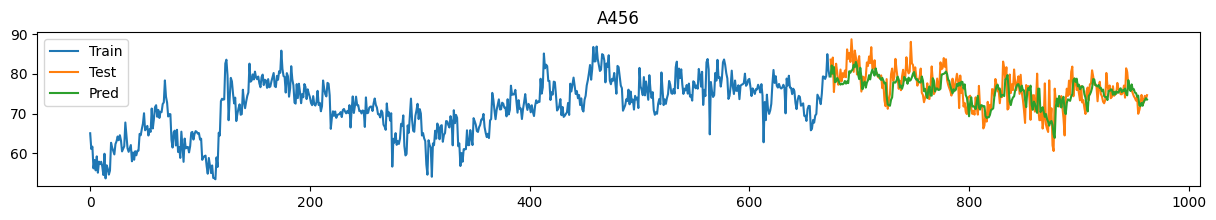

In [11]:
arima_model(A456_train, A456_com_test, A456_test, 'A456')

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  700
Model:             SARIMAX(4, 0, 0)x(2, 0, 0, 25)   Log Likelihood               -1890.322
Date:                            Mon, 13 Jan 2025   AIC                           3796.645
Time:                                    17:55:24   BIC                           3833.053
Sample:                                         0   HQIC                          3810.719
                                            - 700                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4418      1.354      3.280      0.001       1.788       7.096
ar.L1          0.5573      0.035   

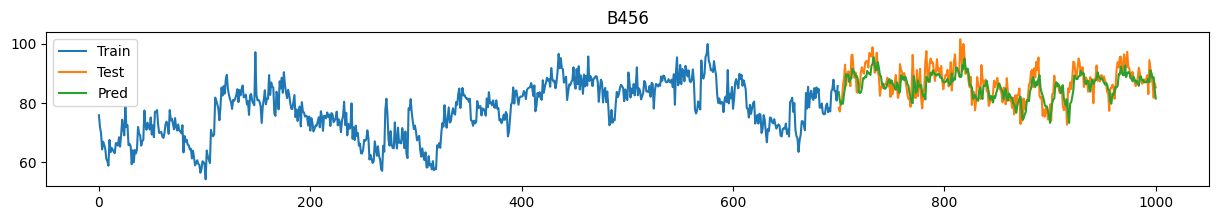

In [12]:
arima_model(B456_train, B456_com_test, B456_test, 'B456')